In [31]:
import data.prem_data_collection
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupKFold, cross_val_score

In [32]:
importlib.reload(data.prem_data_collection)
df = data.prem_data_collection.df

                        name Squad avg_age Foreigners  matchday  cumsum_pts  \
0                    Arsenal    42    24.0         25         1           3   
1                    Arsenal    42    24.0         25         2           6   
2                    Arsenal    42    24.0         25         3           9   
3                    Arsenal    42    24.0         25         4          12   
4                    Arsenal    42    24.0         25         5          15   
..                       ...   ...     ...        ...       ...         ...   
755  Wolverhampton Wanderers    43    25.8         34        34          37   
756  Wolverhampton Wanderers    43    25.8         34        35          40   
757  Wolverhampton Wanderers    43    25.8         34        36          40   
758  Wolverhampton Wanderers    43    25.8         34        37          41   
759  Wolverhampton Wanderers    43    25.8         34        38          41   

     cumsum_xpts  non-penalty xGD  pressing intensi

In [33]:
train_df = df[df["matchday"] <= 4]
test_df = df[df["matchday"] == 5].copy()

X_train = train_df.drop(columns=["name", "relegated"])
y_train = train_df["relegated"]

X_test = test_df.drop(columns=["name", "relegated"])
y_test = test_df["relegated"]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# from RandomForest module 
test_df["relegation_proba"] = model.predict_proba(X_test)[:, 1]

print(test_df[["name", "matchday", "relegation_proba"]].sort_values("relegation_proba", ascending=False))

                        name  matchday  relegation_proba
612              Southampton         5              0.67
346                    Leeds         5              0.56
384                Leicester         5              0.50
80               Bournemouth         5              0.12
574        Nottingham Forest         5              0.12
688                 West Ham         5              0.08
42               Aston Villa         5              0.08
536         Newcastle United         5              0.06
156                 Brighton         5              0.06
308                   Fulham         5              0.05
232           Crystal Palace         5              0.04
498        Manchester United         5              0.04
118                Brentford         5              0.02
650                Tottenham         5              0.01
4                    Arsenal         5              0.01
270                  Everton         5              0.01
194                  Chelsea   

In [34]:
prob_list = []

for md in sorted(df["matchday"].unique()):

    train_df = df[df["matchday"] < md]
    test_df = df[df["matchday"] == md].copy()

    # when md = 1 there exists not training data
    if train_df.empty or test_df.empty:
        continue

    X_train = train_df.drop(columns=["name", "relegated"])
    y_train = train_df["relegated"]

    X_test = test_df.drop(columns=["name", "relegated"])

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    test_df["relegation_proba"] = model.predict_proba(X_test)[:, 1]
    test_df["matchday"] = md

    prob_list.append(test_df[["name", "matchday", "relegation_proba"]])

# combines all probabilities into one df so easier to visualise 
relegation_probs = pd.concat(prob_list)

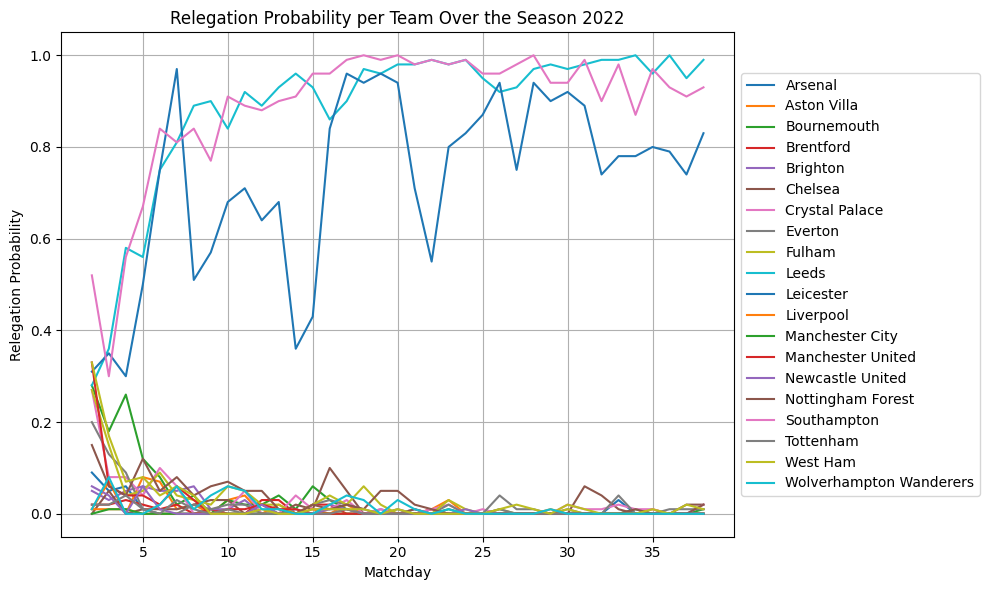

In [35]:
plt.figure(figsize=(10, 6))

for team in relegation_probs["name"].unique():
    team_data = relegation_probs[relegation_probs["name"] == team]
    plt.plot(team_data["matchday"], team_data["relegation_proba"], label=team)

plt.xlabel("Matchday")
plt.ylabel("Relegation Probability")
season = data.prem_data_collection.prem_season
plt.title(f"Relegation Probability per Team Over the Season {(season)}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# from RandomForest
importances = model.feature_importances_

# match them to column names
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)

                         Feature  Importance
1                        avg_age    0.287506
0                          Squad    0.126608
15              avg_player_value    0.104132
10               points_per_game    0.073647
2                     Foreigners    0.067608
8   defending pressing intensity    0.057269
13              tactical_balance    0.051575
12                 defense_solid    0.044751
11               attack_strength    0.044671
14               non-penality GD    0.037202
6                non-penalty xGD    0.033759
9         goal_difference_so_far    0.032019
7             pressing intensity    0.018019
4                     cumsum_pts    0.010116
3                       matchday    0.006381
5                    cumsum_xpts    0.004736
